# Opinion Mining & Sentiment Analysis: Deep Learning Techniques

**Text Mining**

_Prof. Gianluca Moro^, Dott. Ing. Nicola Piscaglia° – DISI, University of Bologna_

^jeremymejia.ekel@studio.unibo.it


°jeremymejia.ekel@bbscommunity.it


**Bologna Business School** - Alma Mater Studiorum Università di Bologna

## Setup

Import libraries

In [1]:
import gzip
import numpy as np
import pandas as pd
import gensim
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
#download function
import os
from urllib.request import urlretrieve
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

### Dataset: Movie Reviews

We have a collection of user reviews extracted from IMDb (the _Internet Movie Database_) labeled as positive or negative.

We want to train a model to understand the positive or negative orientation of any review.

We start by loading the training dataset, containing 25,000 samples with two attributes
- `label` indicates the orientation of the review, can be "pos" or "neg"
- `text` contains the full text of the review

In [0]:
download("imdb-train.csv.gz", "https://github.com/jeremyekel/Opinion-Mining-And-Sentiment-Analysis/raw/master/data/imdb-train.csv.gz")

In [0]:
train_set = pd.read_csv("imdb-train.csv.gz", sep="\t", names=["label", "text"])

In [5]:
train_set.shape

(25000, 2)

In [0]:
# Increasing the length of displayed text
pd.options.display.max_colwidth = 100

In [7]:
train_set.head()

,label,text
0,pos,Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school l...
1,neg,Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a t...
2,pos,"If you like adult comedy cartoons, like South Park, then this is nearly a similar format about t..."
3,neg,Robert DeNiro plays the most unbelievably intelligent illiterate of all time. This movie is so w...
4,pos,"Bromwell High is nothing short of brilliant. Expertly scripted and perfectly delivered, this sea..."


In [0]:
# Replacing <br /> with \n
def strip_tags(text):
    return text.replace("<br />", "\n")

In [0]:
train_set["text"] = train_set["text"].apply(strip_tags)

Positive and negative reviews are evenly distributed

In [10]:
train_set["label"].value_counts()

pos    12500
neg    12500
Name: label, dtype: int64

## Multi-Layer Perceptron

In their usual form, neural networks are composed by a stack of _densely connected_ layers of nodes: each node in a layer receives the output of all nodes of the underlying layer. Such networks are also known as _multi-layer perceptrons_.

A MLP receives a vector as input and its topmost layer produces a vector as output, an arbitrary number of _hidden layers_ can be inserted inbetween to produce intermediate representations of data

In [0]:
# Training a neural network for sentiment classification by initializing a vector space using tf.idf term weighting and filtering out very rare terms
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=3)

train_dtm = vect.fit_transform(train_set["text"])

In [12]:
# Extracting number of distinct terms in the vector space that are used to define the structure of the neural network
num_terms = len(vect.get_feature_names())
num_terms

35852

We want our neural network to indicate in output the correct class of each review, either "pos" or "neg"

For this, we must extract from the `label` column a "target" matrix, where each row contains the values which the network should give as output for each review
- `[1, 0]` for positive reviews
- `[0, 1]` for negative reviews

In [0]:
# Function to convert a given pos/neg labels series into a target matrix
def make_target(labels):
    return pd.DataFrame({
        "pos": labels == "pos",
        "neg": labels == "neg"
    }).astype(int)

In [0]:
train_target = make_target(train_set["label"])

In [15]:
train_target.head()

,pos,neg
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0


In [0]:
# Defining neural network structure
from keras.models import Sequential
model = Sequential()

**First Model**

- Using `softmax` activation function to ensure that the output is a valid probability distribution
- We will never get a perfect `[1, 0]` as output in practice, but we will get outputs like `[0.99, 0.01]`
- Specifying `input_dim` with the size of input vectors (distinct terms)

In [0]:
from keras.layers import Dense
model.add(Dense(2, activation="softmax", input_dim=num_terms))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 71706     
Total params: 71,706
Trainable params: 71,706
Non-trainable params: 0
_________________________________________________________________


In this case we have 35,852×2 = 71,704 weights + 2 biases = 71,706 trainable parameters

In [0]:
# Compile to provide some general settings of the network and initialize accordingly the underlying TensorFlow data structures
# Optimizer 'Adam' used to train the network
# 'Cross Entropy' penalizes outputs which are not close to 1 on the correct class
# Metrics can be computed for evaluation purposes 

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
# Fit the network 'train_dtm' and 'train_target'
fit_history = model.fit(train_dtm, train_target, batch_size=200, epochs=10)

Epoch 1/10
25000/25000 [==============================] - 4s 166us/step - loss: 0.6566 - accuracy: 0.8057
Epoch 2/10
25000/25000 [==============================] - 4s 154us/step - loss: 0.5871 - accuracy: 0.8648
Epoch 3/10
25000/25000 [==============================] - 4s 153us/step - loss: 0.5327 - accuracy: 0.8770
Epoch 4/10
25000/25000 [==============================] - 4s 151us/step - loss: 0.4892 - accuracy: 0.8867
Epoch 5/10
25000/25000 [==============================] - 4s 153us/step - loss: 0.4535 - accuracy: 0.8929
Epoch 6/10
25000/25000 [==============================] - 4s 155us/step - loss: 0.4236 - accuracy: 0.9002
Epoch 7/10
25000/25000 [==============================] - 4s 154us/step - loss: 0.3982 - accuracy: 0.9061
Epoch 8/10
25000/25000 [==============================] - 4s 152us/step - loss: 0.3762 - accuracy: 0.9110
Epoch 9/10
25000/25000 [==============================] - 4s 155us/step - loss: 0.3571 - accuracy: 0.9149
Epoch 10/10
25000/25000 [=====================

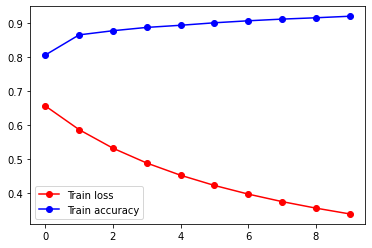

In [21]:
plt.plot(fit_history.history["loss"], "ro-")
plt.plot(fit_history.history["accuracy"], "bo-")
plt.legend(["Train loss", "Train accuracy"]);

We can see in the plot how the loss progressively decreases and accuracy progressively increases through training epochs

In [22]:
# Getting raw ouput given by the network
model.predict(train_dtm[0])

array([[0.60513353, 0.39486644]], dtype=float32)

In [23]:
# Getting predicted class index
model.predict_classes(train_dtm[0])

array([0])

Let's now evaluate the network on a separate test set of labeled reviews, provided in the `imdb-test.csv.gz` file

In [0]:
download("imdb-test.csv.gz", "https://github.com/jeremyekel/Opinion-Mining-And-Sentiment-Analysis/raw/master/data/imdb-test.csv.gz")

In [0]:
test_set = pd.read_csv("imdb-test.csv.gz", sep="\t", names=["label", "text"])

In [26]:
test_set.head(5)

,label,text
0,pos,I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit ...
1,neg,Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the ter...
2,pos,"My boyfriend and I went to watch The Guardian.At first I didn't want to watch it, but I loved th..."
3,neg,This is a pale imitation of 'Officer and a Gentleman.' There is NO chemistry between Kutcher and...
4,pos,My yardstick for measuring a movie's watch-ability is if I get squirmy. If I start shifting posi...


In [27]:
test_set["label"].value_counts()

pos    12500
neg    12500
Name: label, dtype: int64

In [0]:
# Replacing <br /> with \n
test_set["text"] = test_set["text"].apply(strip_tags)

In [0]:
test_dtm = vect.transform(test_set["text"])

In [0]:
# Function to convert a given pos/neg labels series into a target matrix
test_target = make_target(test_set["label"])

In [31]:
# Evaluating the model
model.evaluate(test_dtm, test_target)

25000/25000 [==============================] - 4s 155us/step


[0.3992735678291321, 0.8705199956893921]

**Accuracy:** 0.869

**Second Model**

In [0]:
model = Sequential()
model.add(Dense(128, input_dim=num_terms))

The output of these 128 will be fed to the output layer, composed as above by 2 nodes with softmax activation

In [0]:
# Output of 128 nodes will be fed to the output layer and composed as above by 2 nodes with softmax activation
model.add(Dense(2, activation="softmax"))

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               4589184   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 4,589,442
Trainable params: 4,589,442
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compile to provide some general settings of the network and initialize accordingly the underlying TensorFlow data structures
# Optimizer 'Adam' used to train the network
# 'Cross Entropy' penalizes outputs which are not close to 1 on the correct class
# Metrics can be computed for evaluation purposes 

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

To keep compute times limited, we fit this and subsequent networks running only 3 training epochs

In [36]:
# Fit the network 'train_dtm' and 'train_target'
model.fit(train_dtm, train_target, batch_size=200, epochs=3)

Epoch 1/3
25000/25000 [==============================] - 4s 172us/step - loss: 0.4111 - accuracy: 0.8478
Epoch 2/3
25000/25000 [==============================] - 4s 170us/step - loss: 0.1651 - accuracy: 0.9454
Epoch 3/3
25000/25000 [==============================] - 4s 171us/step - loss: 0.0878 - accuracy: 0.9769


In [37]:
# Evaluating the model
model.evaluate(test_dtm, test_target)

25000/25000 [==============================] - 4s 153us/step


[0.3186801377058029, 0.8703600168228149]

**Accuracy:** 0.871

**Third Model**

Replicating model using sigmoid activation in the hidden layer.

In [0]:
model = Sequential([
    Dense(128, activation="sigmoid", input_dim=num_terms),
    Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [39]:
# Fit the network 'train_dtm' and 'train_target'
model.fit(train_dtm, train_target, batch_size=200, epochs=3)

Epoch 1/3
25000/25000 [==============================] - 4s 171us/step - loss: 0.6103 - accuracy: 0.7912
Epoch 2/3
25000/25000 [==============================] - 4s 169us/step - loss: 0.4230 - accuracy: 0.8842
Epoch 3/3
25000/25000 [==============================] - 4s 169us/step - loss: 0.2874 - accuracy: 0.9166


In [40]:
# Evaluating the model
model.evaluate(test_dtm, test_target)

25000/25000 [==============================] - 4s 154us/step


[0.3239750177383423, 0.8792399764060974]

**Accuracy:** 0.877

Fourth Model

In [0]:
model = Sequential([
    Dense(256, activation="sigmoid", input_dim=num_terms),
    Dense(64, activation="sigmoid"),
    Dense(16, activation="sigmoid"),
    Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               9178368   
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
Total params: 9,195,890
Trainable params: 9,195,890
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Fit the network 'train_dtm' and 'train_target'
model.fit(train_dtm, train_target, batch_size=200, epochs=3)

Epoch 1/3
25000/25000 [==============================] - 4s 177us/step - loss: 0.6992 - accuracy: 0.5447
Epoch 2/3
25000/25000 [==============================] - 4s 173us/step - loss: 0.6162 - accuracy: 0.7732
Epoch 3/3
25000/25000 [==============================] - 4s 175us/step - loss: 0.2828 - accuracy: 0.8988


In [44]:
# Evaluating the model
model.evaluate(test_dtm, test_target)

25000/25000 [==============================] - 4s 153us/step


[0.2789417101621628, 0.8850399851799011]

**Accuracy:** 0.886

## Word Embedding

A _word embedding_ model is a dictionary mapping each known word to a **N-dimensional vector**.

The **gensim** library provides means to represent and build word embedding models.

### Training a Word2Vec model

We have a set of 5,000 movie reviews without any labeling: we can't train a sentiment classifier on them but we can train a word embedding model

We read the compressed text file `imdb-unsup-5k.txt.gz`, containing one review per line

In [0]:
download("imdb-unsup-5k.txt.gz", "https://github.com/jeremyekel/Opinion-Mining-And-Sentiment-Analysis/raw/master/data/imdb-unsup-5k.txt.gz")

In [0]:
with gzip.open("imdb-unsup-5k.txt.gz", "rt") as f:
    we_train_set = [strip_tags(line.strip()) for line in f]

We have to preprocess each review by splitting text into tokens

gensim, the library used to train the word embedding model, provides a simple utility function for this
- alternatively any tokenization function can be used, e.g. `nltk.word_tokenize`

In [0]:
from gensim.utils import simple_preprocess

In [48]:
%%time
we_train_tokens = [simple_preprocess(text) for text in we_train_set]

CPU times: user 1.01 s, sys: 22.7 ms, total: 1.04 s
Wall time: 1.04 s


In [49]:
we_train_set[0][:82]

'I admit, the great majority of films released before say 1933 are just not for me.'

In [50]:
we_train_tokens[0][:8]

['admit', 'the', 'great', 'majority', 'of', 'films', 'released', 'before']

The most important parameter is the size of the word vectors we want to obtain
- in the original Word2Vec paper 300 is indicated as a good value
- here we use 50 as a tradeoff between accuracy and efficiency

In [0]:
wordvecs_size = 50

Other relevant parameters are
- the _window size_, i.e. the number of words before and after any word to consider as its context
- the minimum appearances of a term to be included in the model

In [52]:
%%time
wv_model = gensim.models.Word2Vec(
    we_train_tokens,
    size=wordvecs_size,
    window=5,
    min_count=5
)

CPU times: user 14.2 s, sys: 52.1 ms, total: 14.2 s
Wall time: 8.52 s


Our Word2Vec model is now trained, we can get a reference to the word->vector mapping itself `wv` and drop the rest of the model object to free some memory

In [0]:
wv = wv_model.wv
del wv_model

### Exploring the word embedding model

In [54]:
# Distinct terms in the model
len(wv.vocab)

12070

In [55]:
# First commong terms
wv.index2word[:10]

['the', 'and', 'of', 'to', 'is', 'in', 'it', 'this', 'that', 'as']

In [56]:
# Sample of vector 'excellent' word
wv.word_vec("excellent")

array([ 9.0692371e-02, -2.5783143e+00, -1.3506367e+00,  2.3988014e-01,
        1.5038668e-01,  5.4138020e-02,  5.5156940e-01,  7.9598844e-01,
        4.7793037e-01,  1.2590929e+00,  5.4246068e-01, -7.9931659e-01,
        5.0815415e-01, -5.8446544e-01,  2.2800026e+00,  8.5092521e-01,
        4.6415684e-01,  3.5409518e-02,  1.3116820e+00, -6.8750924e-01,
       -3.7776271e-01,  3.4756464e-01, -6.1254758e-01,  8.0525899e-01,
        1.0199246e+00, -1.3023434e+00, -1.8168657e+00,  4.2487559e-01,
        1.1203139e+00,  1.1096715e+00,  9.2268783e-01, -7.4720854e-01,
       -1.3459345e+00, -1.1870738e+00,  1.5507081e-02,  1.3777466e+00,
       -4.7890621e-01, -5.2592331e-01, -1.2132574e+00, -1.5812813e+00,
        1.0392408e+00,  1.0805709e+00,  2.2071030e+00,  2.4046151e-01,
        1.1384501e+00,  2.2097389e-01, -5.4840070e-01,  1.9764748e-01,
       -2.6135790e-01, -2.1806841e-03], dtype=float32)

In [0]:
# Compute and cache normalized vectors
wv.init_sims()

In [58]:
# True indicates to normalize the vector
wv.word_vec("excellent", True)

array([ 1.26859695e-02, -3.60652328e-01, -1.88925877e-01,  3.35542224e-02,
        2.10359562e-02,  7.57277850e-03,  7.71530420e-02,  1.11342162e-01,
        6.68524802e-02,  1.76120818e-01,  7.58789256e-02, -1.11807704e-01,
        7.10801557e-02, -8.17545131e-02,  3.18924755e-01,  1.19026668e-01,
        6.49258494e-02,  4.95305238e-03,  1.83476925e-01, -9.61681902e-02,
       -5.28411157e-02,  4.86170352e-02, -8.56826156e-02,  1.12638921e-01,
        1.42666161e-01, -1.82170644e-01, -2.54141569e-01,  5.94312251e-02,
        1.56708524e-01,  1.55219868e-01,  1.29064769e-01, -1.04518875e-01,
       -1.88268140e-01, -1.66046843e-01,  2.16911687e-03,  1.92717984e-01,
       -6.69889823e-02, -7.35656917e-02, -1.69709384e-01, -2.21188247e-01,
        1.45368099e-01,  1.51149318e-01,  3.08727622e-01,  3.36355455e-02,
        1.59245402e-01,  3.09096351e-02, -7.67098069e-02,  2.76467558e-02,
       -3.65585126e-02, -3.05032183e-04], dtype=float32)

In [0]:
# Using 'cosine_similarities' function to compute similarity among the vectors
similarities_to_excellent = wv.cosine_similarities(
    wv.word_vec("excellent"),
    wv.vectors
)

In [60]:
similarities_to_excellent[:5]

array([ 0.11190797,  0.21383691,  0.12925905, -0.1857107 ,  0.2399035 ],
      dtype=float32)

In [61]:
pd.Series(
    similarities_to_excellent,
    wv.index2word
).sort_values(ascending=False).head(10)

excellent      1.000000
outstanding    0.922494
impressive     0.895074
brilliant      0.889264
amazing        0.883686
directing      0.876207
fine           0.872892
terrific       0.857629
fantastic      0.857597
direction      0.855202
dtype: float32

In [62]:
# Similar words
wv.most_similar("excellent")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('outstanding', 0.922494113445282),
 ('impressive', 0.8950737714767456),
 ('brilliant', 0.8892644047737122),
 ('amazing', 0.8836863040924072),
 ('directing', 0.8762070536613464),
 ('fine', 0.8728923797607422),
 ('terrific', 0.8576288223266602),
 ('fantastic', 0.8575965166091919),
 ('direction', 0.8552022576332092),
 ('superb', 0.8542619943618774)]

In [63]:
wv.most_similar("terrible")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('horrible', 0.9485824108123779),
 ('awful', 0.9209786653518677),
 ('hilarious', 0.9109424948692322),
 ('ok', 0.8960175514221191),
 ('ridiculous', 0.8959105610847473),
 ('decent', 0.8881834745407104),
 ('predictable', 0.8697757720947266),
 ('boring', 0.863764226436615),
 ('scary', 0.8630543947219849),
 ('cool', 0.8560620546340942)]

Another powerful function of word embedding models is to find words with specific syntactic and semantic relationships using vector arithmetics

Consider the relationship _"man" is to "woman" as "actor" is to X_ where the model has to find out that X = "actress"

Word2Vec produces vectors in such a way that _"man" - "woman" = "actor" - X_, so we can find X as the term whose vector is closest to _"actor" + "woman" - "man"_

Let's produce the vector representation of X...

In [0]:
composition = (wv.word_vec("actor", True)
             + wv.word_vec("woman", True)
             - wv.word_vec("man", True))

In [65]:
pd.Series(
    wv.cosine_similarities(composition, wv.vectors),
    wv.index2word
).sort_values(ascending=False).head(10)

actor          0.922859
actress        0.908202
role           0.879228
chaney         0.815216
performance    0.806804
bruce          0.799823
oscar          0.787288
talented       0.784481
star           0.782140
davis          0.780560
dtype: float32

In [66]:
# Similar words
wv.most_similar(
    positive=["actor", "woman"],
    negative=["man"]
)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('actress', 0.9082022905349731),
 ('role', 0.8792279958724976),
 ('chaney', 0.8152158856391907),
 ('performance', 0.8068039417266846),
 ('bruce', 0.7998225688934326),
 ('oscar', 0.7872880101203918),
 ('talented', 0.7844809889793396),
 ('star', 0.7821401953697205),
 ('davis', 0.7805596590042114),
 ('accent', 0.7779046893119812)]

According to randomness in the training process, the correct answer "actress" might be the most similar word or very close to it, but still the confidence of the model is limited

We proceed our analysis on a pretrained GloVe (_Global Vectors_) word embedding model, whose training procedure is similar to Word2Vec.

In [0]:
download("glove.npz", "https://github.com/jeremyekel/Opinion-Mining-And-Sentiment-Analysis/raw/master/data/glove.npz")

In [0]:
with np.load("glove.npz") as f:
    glove_words = f["words"]
    glove_vectors = f["vectors"]

In [69]:
wordvecs_size = glove_vectors.shape[1]
wordvecs_size

100

In [0]:
# Creating the word embedding model from the words
wv = gensim.models.KeyedVectors(wordvecs_size)
wv[glove_words.tolist()] = glove_vectors
wv.init_sims()

In [71]:
# Similar words
wv.most_similar(
    positive=["actor", "woman"],
    negative=["man"]
)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('actress', 0.9073609113693237),
 ('comedian', 0.6890829205513),
 ('actresses', 0.6826434135437012),
 ('screenwriter', 0.6554961204528809),
 ('starred', 0.6533135175704956),
 ('starring', 0.6514240503311157),
 ('actors', 0.6402771472930908),
 ('dancer', 0.6378583908081055),
 ('singer', 0.6346279382705688),
 ('filmmaker', 0.6279778480529785)]

In [72]:
# Similar words
wv.most_similar(
    positive=["mouse", "dogs", "cats"],
    negative=[         "dog",  "cat"]
)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('mice', 0.710668683052063),
 ('rabbits', 0.681904673576355),
 ('rodents', 0.6771590709686279),
 ('rats', 0.6427716016769409),
 ('animals', 0.6243681907653809),
 ('monkeys', 0.6002902984619141),
 ('ferrets', 0.5910987854003906),
 ('mammals', 0.5888075828552246),
 ('foxes', 0.5750464200973511),
 ('raccoons', 0.5635854005813599)]

In [73]:
# Similar words
wv.most_similar(
    positive=["france", "rome",  "berlin"],
    negative=[          "italy", "germany"]
)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('paris', 0.7584174871444702),
 ('cairo', 0.6146870851516724),
 ('london', 0.5959091186523438),
 ('versailles', 0.5937519669532776),
 ('vienna', 0.5896108150482178),
 ('brussels', 0.5775601863861084),
 ('petersburg', 0.5704914331436157),
 ('palace', 0.5681281089782715),
 ('sorbonne', 0.5556104183197021),
 ('strasbourg', 0.555298388004303)]

Another method provided by the model is `doesnt_match` finding the word which is the least related to the others in a given list

In [74]:
# Word is the least related
wv.doesnt_match(["cat", "mouse", "dog", "keyboard", "frog"])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'keyboard'

### Representing text with word embedding

Leveraging the word embedding model in a neural network for sentiment classification.

In [75]:
%%time
train_tokens = [gensim.utils.simple_preprocess(text) for text in train_set["text"]]

CPU times: user 4.95 s, sys: 176 ms, total: 5.12 s
Wall time: 5.07 s


In [76]:
train_set["text"][0][:34]

'Bromwell High is a cartoon comedy.'

In [77]:
train_tokens[0][:5]

['bromwell', 'high', 'is', 'cartoon', 'comedy']

In [0]:
# Converting lists of text tokens into lists of indices of terms in the word embedding model
train_indices = [
    [wv.vocab[word].index for word in text if word in wv.vocab]
    for text in train_tokens
]

In [79]:
train_indices[0][:5]

[152, 14, 7362, 2841, 20]

In [80]:
# Translating back to words
[wv.index2word[i] for i in train_indices[0][:5]]

['high', 'is', 'cartoon', 'comedy', 'it']

In [0]:
# Represnting each review with normalized vector mean of words contained in it.
train_we_repr = np.vstack([wv.vectors_norm[indices].mean(0) for indices in train_indices])

In [0]:
# Creating MLP network with one hidden layer accepting such vectors in input
model = Sequential([
    Dense(128, activation="sigmoid", input_dim=wordvecs_size),
    Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [83]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 258       
Total params: 13,186
Trainable params: 13,186
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Fit the network 'train_we_repr' and 'train_target'
model.fit(train_we_repr, train_target, batch_size=20, epochs=10)

Epoch 1/10
25000/25000 [==============================] - 3s 116us/step - loss: 0.6527 - accuracy: 0.6302
Epoch 2/10
25000/25000 [==============================] - 3s 116us/step - loss: 0.5701 - accuracy: 0.7241
Epoch 3/10
25000/25000 [==============================] - 3s 114us/step - loss: 0.5183 - accuracy: 0.7560
Epoch 4/10
25000/25000 [==============================] - 3s 114us/step - loss: 0.4927 - accuracy: 0.7707
Epoch 5/10
25000/25000 [==============================] - 3s 113us/step - loss: 0.4775 - accuracy: 0.7787
Epoch 6/10
25000/25000 [==============================] - 3s 113us/step - loss: 0.4694 - accuracy: 0.7824
Epoch 7/10
25000/25000 [==============================] - 3s 112us/step - loss: 0.4647 - accuracy: 0.7845
Epoch 8/10
25000/25000 [==============================] - 3s 113us/step - loss: 0.4613 - accuracy: 0.7853
Epoch 9/10
25000/25000 [==============================] - 3s 113us/step - loss: 0.4570 - accuracy: 0.7894
Epoch 10/10
25000/25000 [=====================

In [0]:
# Preprocessing test reviews
# Extracting tokens and coverting them to indices
test_tokens = [gensim.utils.simple_preprocess(text) for text in test_set["text"]]
test_indices = [
    [wv.vocab[word].index for word in text if word in wv.vocab]
    for text in test_tokens
]

In [0]:
# Obtaining Word of Vectors means for each review
test_we_repr = np.vstack([wv.vectors_norm[indices].mean(0) for indices in test_indices])

In [87]:
# Evaluating the model
model.evaluate(test_we_repr, test_target)

25000/25000 [==============================] - 1s 43us/step


[0.45939572566986087, 0.7887200117111206]

**Accuracy:** 0.781

## Recurrent neural networks

MLPs are _feed-forward_ networks: their output at any time is only dependent from their input at the same time.

### Sequential data
Leveraging the word embedding model, we represent each review with the **sequence of word vectors** for the terms contained in it
- in this way, we consider both the identity of words (the vectors) and their order!

We need to make all sequences of the same length (the T term above): we set a desired sequence size T, then we trim longer sequences to that size (taking the final T elements) and pad shorter sequences with null values: Keras' `pad_sequences` function does this
- larger T values would make training much slower

In [0]:
from keras.preprocessing.sequence import pad_sequences
max_words = 200
train_seq = pad_sequences(train_indices, max_words)

In [89]:
train_seq

array([[    0,     0,     0, ...,    12,    20, 75360],
       [    0,     0,     0, ...,    30,   541,  3442],
       [    0,     0,     0, ...,   219,   191,   219],
       ...,
       [    0,     0,     0, ..., 29080,  1075,    48],
       [  460,     4,    30, ...,   227,    30,  4254],
       [    0,     0,     0, ...,  1666,    13, 13664]], dtype=int32)

In [90]:
train_seq.shape

(25000, 200)

### Building the network

Let's now create a neural network which gets such sequences as input

In [0]:
model = Sequential()

In [0]:
# Inserting an Embedding layer, which translates each received value into the word vector from the embedding model
from keras.layers import Embedding
model.add(Embedding(
    input_dim=len(wv.vocab),    # number of distinct vocabulary terms
    output_dim=wordvecs_size,   # size of word vectors (S)
    input_length=max_words,     # length of sequences (T)
    weights=[wv.vectors],       # word vectors
    trainable=False
))

_Gated Recurrent Units_ (GRU) are a simplified version of _Long Short-Term Memory_ (LSTM) units, which can potentially hold information in memory across many time steps; we use here a layer of 128 GRU cells

_Dropout_ randomly drops (sets to zero) a given ratio of input values at each time step: it is a technique to prevent model overfitting

In [0]:
from keras.layers import GRU
model.add(GRU(128, dropout=0.2))

In [0]:
model.add(Dense(2, activation="softmax"))

In [95]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          10000000  
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 258       
Total params: 10,088,194
Trainable params: 88,194
Non-trainable params: 10,000,000
_________________________________________________________________


We can now compile the network and train it on the padded sequences of word indices
- training of RNNs is quite slow, we again limit training to 3 epochs

In [96]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_seq, train_target, batch_size=200, epochs=3)

Epoch 1/3
25000/25000 [==============================] - 46s 2ms/step - loss: 0.6090 - accuracy: 0.6562
Epoch 2/3
25000/25000 [==============================] - 45s 2ms/step - loss: 0.4557 - accuracy: 0.7894
Epoch 3/3
25000/25000 [==============================] - 45s 2ms/step - loss: 0.3904 - accuracy: 0.8270


In [0]:
test_seq = pad_sequences(test_indices, max_words)

In [98]:
# Evaluating model
model.evaluate(test_seq, test_target)

25000/25000 [==============================] - 27s 1ms/step


[0.36640770977020265, 0.8379600048065186]

## Cross domain classification

We trained our network on reviews of movies and tested its ability to classify sentiment in reviews of movies

The `yelp-test-10k.csv.gz` file contains 10,000 labeled user reviews about restaurants extracted from Yelp

In [0]:
download("yelp-test-10k.csv.gz", "https://github.com/jeremyekel/Opinion-Mining-And-Sentiment-Analysis/raw/master/data/yelp-test-10k.csv.gz")

In [0]:
xdom_set = pd.read_csv("yelp-test-10k.csv.gz", sep="\t", names=["label", "text"])

In [101]:
xdom_set.head(5)

,label,text
0,pos,My wife took me here on my birthday for breakfast and it was excellent. The weather was perfec...
1,neg,U can go there n check the car out. If u wanna buy 1 there? That's wrong move! If u even want a...
2,pos,"I have no idea why some people give bad reviews about this place. It goes to show you, you can ..."
3,neg,Disgusting! Had a Groupon so my daughter and I tried it out. Very outdated and gaudy 80's sty...
4,pos,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!! It's very convenient and surrounded by a lot of..."


In [102]:
xdom_set["label"].value_counts()

pos    5000
neg    5000
Name: label, dtype: int64

In [0]:
# Preprocessing
xdom_set["text"] = xdom_set["text"].apply(strip_tags)
xdom_tokens = [gensim.utils.simple_preprocess(text) for text in xdom_set["text"]]
xdom_indices = [
    [wv.vocab[word].index for word in text if word in wv.vocab]
    for text in xdom_tokens
]
xdom_seq = pad_sequences(xdom_indices, max_words)
xdom_target = make_target(xdom_set["label"])

In [104]:
# Evaluating model
model.evaluate(xdom_seq, xdom_target)

10000/10000 [==============================] - 11s 1ms/step


[0.3896024509429932, 0.817300021648407]

## Fine tuning the network

In the `yelp-train-2k.csv.gz` we have a set of 2,000 labeled Yelp reviews which can be used for training

We would like to make use of these in-domain reviews, without throwing away the model trained on the richer set of cross-domain reviews

We can "tune" the trained model with an additional training run on the new set of reviews, thus making it more oriented to the new domain and still using knowledge from the other

Let's load and view a summary of the file...

In [0]:
download("yelp-train-2k.csv.gz", "https://github.com/jeremyekel/Opinion-Mining-And-Sentiment-Analysis/raw/master/data/yelp-train-2k.csv.gz")

In [0]:
tune_set = pd.read_csv("yelp-train-2k.csv.gz", sep="\t", names=["label", "text"])

In [107]:
tune_set.head(5)

,label,text
0,pos,Great local yoga studio. Had flexible hours like early morning and late night to fit any schedu...
1,neg,"I've been craving a good roast beef sandwich for a few days now, and finally had the chance to ..."
2,pos,"Super tasty, love the cozy atmosphere, excellent and friendly service! The naan was a bit thin..."
3,neg,"After waiting 4 days to get an appointment, Flores was a no show and didn't even bother to call."
4,pos,I have had my kitty Miller for 8 years. She has never been to any other vet. I like this place...


In [108]:
tune_set["label"].value_counts()

pos    1000
neg    1000
Name: label, dtype: int64

In [0]:
# Preprocessing
tune_set["text"] = tune_set["text"].apply(strip_tags)
tune_tokens = [gensim.utils.simple_preprocess(text) for text in tune_set["text"]]
tune_indices = [
    [wv.vocab[word].index for word in text if word in wv.vocab]
    for text in tune_tokens
]
tune_seq = pad_sequences(tune_indices, max_words)
tune_target = make_target(tune_set["label"])

In [110]:
model.fit(tune_seq, tune_target, epochs=5, batch_size=200)

Epoch 1/5
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3863 - accuracy: 0.8250
Epoch 2/5
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3084 - accuracy: 0.8655
Epoch 3/5
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2893 - accuracy: 0.8775
Epoch 4/5
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2678 - accuracy: 0.8955
Epoch 5/5
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2415 - accuracy: 0.8985


In [111]:
model.evaluate(xdom_seq, xdom_target)

10000/10000 [==============================] - 11s 1ms/step


[0.21754012694358826, 0.9143000245094299]

**Accuracy:** 0.876

We successfully boosted the model accuracy, combining even limited knowledge of the target domain with large knowledge extracted from a different domain